In [1]:
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# fastdtw 패키지 설치
!pip install fastdtw
!pip install tslearn
!pip install imbalanced-learn  # SMOTE를 사용하기 위해 imbalanced-learn 설치


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542084 sha256=186df7da63bcd26cd25f3ef4271288d2cf82ef0bd373d7d96100aab5b844fed0
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score, confusion_matrix
from urllib.request import urlopen
from io import StringIO
from google.colab import drive
import random
from imblearn.metrics import specificity_score
from scipy.stats import mode
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
from tslearn.metrics import dtw_path
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [4]:
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')

In [5]:
# 데이터 전처리
X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)

# 소수 클래스와 다수 클래스 식별
target_counts = pd.Series(y_train).value_counts()
minority_class = target_counts.idxmin()
majority_class = target_counts.idxmax()

# 소수 클래스 샘플 추출
X_minority = X_train[y_train == minority_class]
X_major = X_train[y_train == majority_class]

# DTW 기반의 합성 데이터 생성 함수
def generate_dtw_synthetic_data(X, num_samples):
    synthetic_data = []
    for _ in range(num_samples):
        idx1, idx2 = np.random.choice(len(X), 2, replace=False)
        dtw_avg = (X[idx1] + X[idx2]) / 2  # Simple average as DTW-based augmentation
        synthetic_data.append(dtw_avg)
    return np.array(synthetic_data)

# 소수 클래스 샘플을 증강하여 원본 데이터에 결합
nCnt = len(X_train) - len(X_minority)  # 생성할 합성 데이터의 수
X_aug = generate_dtw_synthetic_data(X_minority, num_samples=nCnt)
y_aug = np.full(len(X_aug), minority_class)

# 원본 데이터와 합성 데이터 결합
X_synthetic = np.concatenate((X_train, X_aug), axis=0)
y_synthetic = np.concatenate((y_train, y_aug), axis=0)

# DTW 거리 계산 함수
def compute_dtw_distance(series1, series2):
    distance, _ = fastdtw(series1, series2)
    return distance

# X_train과 X_test 사이의 DTW 거리 계산하여 대칭 행렬로 표현
dtw_matrix = np.zeros((len(X_synthetic), len(X_test)))

# DTW 거리 계산
for i, train_series in enumerate(X_synthetic):
    for j, test_series in enumerate(X_test):
        distance = compute_dtw_distance(train_series, test_series)
        dtw_matrix[i, j] = distance

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [7]:
# 10. Stratified K-Fold 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Stratified K-Fold 사용

In [8]:
# 11. 교차 검증 및 모델 학습
best_threshold = None
best_specificity = 0
best_model = None

for fold, (train_index, val_index) in enumerate(skf.split(X_synthetic, y_synthetic)): #X_train_resampled, y_train_resampled로 학습
    print(f"Fold {fold+1}")

    # 데이터 분할
    X_train_fold, X_val_fold = X_synthetic[train_index], X_synthetic[val_index] #X_train_resampled, y_train_resampled로 학습
    y_train_fold, y_val_fold = y_synthetic[train_index], y_synthetic[val_index] #X_train_resampled, y_train_resampled로 학습

    rf_model = RandomForestClassifier(random_state=42)
    # 모델 학습
    rf_model.fit(X_train_fold, y_train_fold)

    # 검증 데이터 예측 (확률값 예측)
    y_pred_proba = rf_model.predict_proba(X_val_fold)[:, 1]

    # 최적 임계값 찾기 (Specificity 최대화)
    thresholds = np.linspace(0, 1, 100)  # 임계값 후보 생성
    for threshold in thresholds:
        y_pred_temp = (y_pred_proba >= threshold).astype(int)
        specificity = specificity_score(y_val_fold, y_pred_temp)
        if specificity > best_specificity:
            best_specificity = specificity
            best_threshold = threshold
            best_model = rf_model # 현재 fold의 모델 저장

print(f"Best Threshold: {best_threshold}")

# 12. 테스트 데이터 예측 (최적 모델 및 임계값 사용)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Best Threshold: 0.9090909090909092


In [9]:
# 예측 함수 정의

# 예측 함수 정의 (최적 모델 및 임계값 사용)
def predict_with_best_rf(X_test):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    return (y_pred_proba >= best_threshold).astype(int)

def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    # LSTM 모델 정의
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 데이터 차원 변경
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    # CNN 모델 정의
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 데이터 차원 변경
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

In [10]:
# Define predictions dictionary
predictions = {
    "Logistic Regression": predict_with_logistic_regression(X_synthetic, y_synthetic, X_test),
    "CART": predict_with_cart(X_synthetic, y_synthetic, X_test),
    "KNN": predict_with_knn(X_synthetic, y_synthetic, X_test),
    "XGBoost": predict_with_xgboost(X_synthetic, y_synthetic, X_test),
    "LSTM": predict_with_lstm(X_synthetic, y_synthetic, X_test),
    "CNN": predict_with_cnn(X_synthetic, y_synthetic, X_test),
    "Best Random Forest": predict_with_best_rf(X_test)  # 최적 RF 모델 예측
}

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:34:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(*

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Logistic Regression 모델 성능:
모델 성능 평가:
정확도: 0.6399
F1-Score: 0.7204
Recall: 0.7567
specificity: 0.4548
혼동 행렬 (Confusion Matrix):
[[151 181]
 [128 398]]


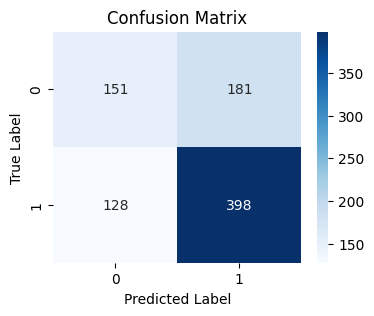

CART 모델 성능:
모델 성능 평가:
정확도: 0.6946
F1-Score: 0.7817
Recall: 0.8916
specificity: 0.3825
혼동 행렬 (Confusion Matrix):
[[127 205]
 [ 57 469]]


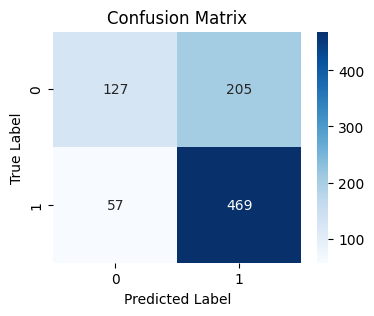

KNN 모델 성능:
모델 성능 평가:
정확도: 0.7401
F1-Score: 0.8066
Recall: 0.8840
specificity: 0.5120
혼동 행렬 (Confusion Matrix):
[[170 162]
 [ 61 465]]


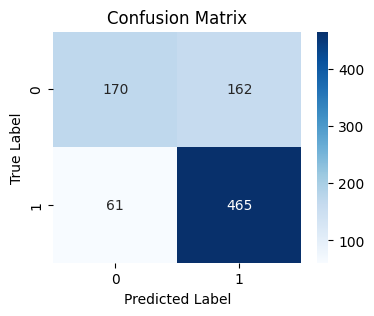

XGBoost 모델 성능:
모델 성능 평가:
정확도: 0.7284
F1-Score: 0.8119
Recall: 0.9563
specificity: 0.3675
혼동 행렬 (Confusion Matrix):
[[122 210]
 [ 23 503]]


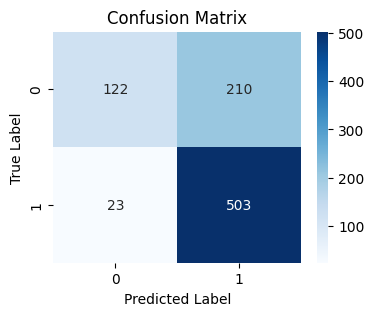

LSTM 모델 성능:
모델 성능 평가:
정확도: 0.6399
F1-Score: 0.7320
Recall: 0.8023
specificity: 0.3825
혼동 행렬 (Confusion Matrix):
[[127 205]
 [104 422]]


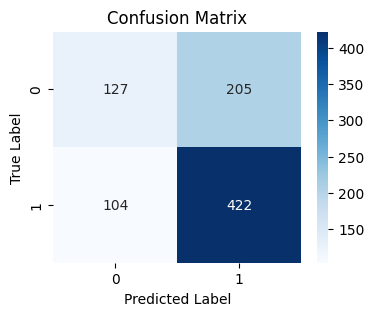

CNN 모델 성능:
모델 성능 평가:
정확도: 0.6678
F1-Score: 0.7444
Recall: 0.7890
specificity: 0.4759
혼동 행렬 (Confusion Matrix):
[[158 174]
 [111 415]]


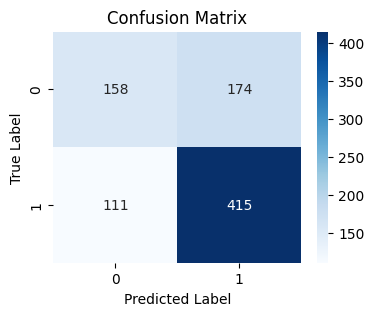

Best Random Forest 모델 성능:
모델 성능 평가:
정확도: 0.5711
F1-Score: 0.4802
Recall: 0.3232
specificity: 0.9639
혼동 행렬 (Confusion Matrix):
[[320  12]
 [356 170]]


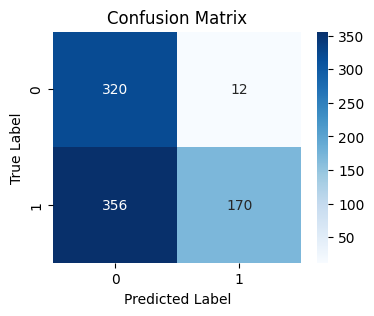

In [11]:
# 성능 평가
for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)

    # 성능 지표 출력
    print(f"{model_name} 모델 성능:")
    print("모델 성능 평가:")
    print(f"정확도: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"specificity: {specificity:.4f}")
    print("혼동 행렬 (Confusion Matrix):")
    print(conf_matrix)

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, pred_y)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# y_test의 샘플링 비율 및 개수 계산
y_test_series = pd.Series(y_test)
class_counts = y_test_series.value_counts() # 클래스별 개수 계산
sampling_ratio = y_test_series.value_counts(normalize=True)  # normalize=True를 사용하여 비율 계산

print("\ny_test 샘플링 비율 및 개수:")
for class_value, ratio in sampling_ratio.items():
    count = class_counts[class_value]
    print(f"클래스 {class_value}: 비율 = {ratio:.4f} (개수 = {count})")


y_test 샘플링 비율 및 개수:
클래스 1: 비율 = 0.6131 (개수 = 526)
클래스 0: 비율 = 0.3869 (개수 = 332)
